# Librerías

In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Hiperparámetros

In [2]:
epochs = 10

In [6]:
import pathlib
dataPath = "../dataPrep/ImgWithBackground/"
# dataDir = tf.keras.utils.get_file('flower_photos', origin=dataPath)
dataDir = pathlib.Path(dataPath)

imageCount = len(list(dataDir.glob('*/*.png')))
print(f'{imageCount} imágenes cargadas')

483 imágenes cargadas


## Crear Dataset

In [7]:
batchSize = 32
imgHeight = 180
imgWidth = 180

validationSplit = 0.2

## Dividir dataset
Dataset para entrenar

In [8]:
trainDS = tf.keras.utils.image_dataset_from_directory(
  dataDir,
  validation_split=validationSplit,
  subset="training",
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

Found 483 files belonging to 2 classes.
Using 387 files for training.


In [9]:
clases = trainDS.class_names

Dataset para validar

In [10]:
valDS = tf.keras.utils.image_dataset_from_directory(
  dataDir,
  validation_split=validationSplit,
  subset="validation",
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

Found 483 files belonging to 2 classes.
Using 96 files for validation.


Cache de los datasets para mejorar rendimiento

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

trainDS = trainDS.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valDS = valDS.cache().prefetch(buffer_size=AUTOTUNE)

# Definición del Modelo
## Capas de aumento
Para agregar variación a los datos e intentar evitar overfitting, agregamos algunas capas que aumentará nuestro dataset al aplicarle rotación, zoom y orientación horizontal aleatoria a las imágenes.

In [12]:
tf.get_logger().setLevel('ERROR')

In [13]:
dataAugmentationLayers = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(imgHeight,
                                  imgWidth,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Antes del resto de las capas, agregamos las capas de aumento y una capa de "Rescaling" para normalizar los valores de cada pixel ([0, 255]) a un rango de [0, 1]

Usamos el optimizer Adam (`tf.keras.optimizers.Adam`), la función de pérdida `tf.keras.losses.SparseCategoricalCrossentropy` y le especificamos la función compile() que queremos obtener precisión como métrica.

In [14]:
cantClases = len(clases)

model = Sequential([
    dataAugmentationLayers,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(cantClases, name="outputs")
])

model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

# Entrenamiento

In [15]:
history = model.fit(
    trainDS,
    validation_data=valDS,
    epochs=epochs
)

Epoch 1/10
13/13 [==============================] - 14s 723ms/step - loss: 0.8261 - accuracy: 0.5323 - val_loss: 0.7041 - val_accuracy: 0.5208
Epoch 2/10
13/13 [==============================] - 9s 669ms/step - loss: 0.6874 - accuracy: 0.5685 - val_loss: 0.6949 - val_accuracy: 0.5208
Epoch 3/10
13/13 [==============================] - 9s 669ms/step - loss: 0.6764 - accuracy: 0.5685 - val_loss: 0.7035 - val_accuracy: 0.5208
Epoch 4/10
13/13 [==============================] - 9s 668ms/step - loss: 0.6823 - accuracy: 0.5685 - val_loss: 0.6864 - val_accuracy: 0.5208
Epoch 5/10
13/13 [==============================] - 9s 730ms/step - loss: 0.6531 - accuracy: 0.5685 - val_loss: 0.6875 - val_accuracy: 0.5208
Epoch 6/10
13/13 [==============================] - 8s 631ms/step - loss: 0.6397 - accuracy: 0.6150 - val_loss: 0.8702 - val_accuracy: 0.5208
Epoch 7/10
13/13 [==============================] - 8s 642ms/step - loss: 0.6277 - accuracy: 0.6667 - val_loss: 0.6382 - val_accuracy: 0.5208
Epoch

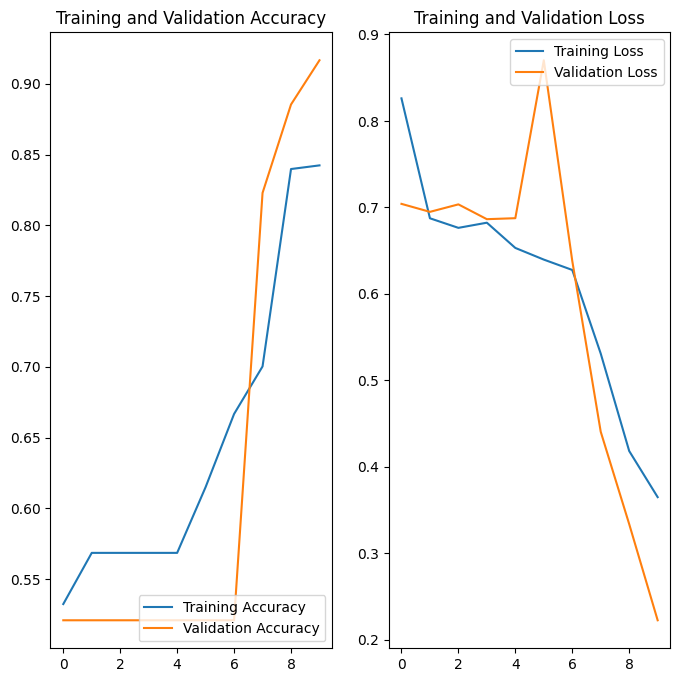

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()